In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import joblib
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import os

In [39]:
# Load dataset on notebook
col_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
    'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]

df = pd.read_csv("../data/kddcup.data_10_percent_corrected", names=col_names)
df = df.drop(columns=["label"])


In [40]:
df = pd.get_dummies(df, columns=["protocol_type", "service", "flag"])

In [41]:
# Standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


In [42]:
# Saving scaler
os.makedirs("../models", exist_ok=True)
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']

In [43]:
# Train & Save Isolation Forest Model
from sklearn.ensemble import IsolationForest

In [44]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(df_scaled)

IsolationForest(contamination=0.05, random_state=42)

In [45]:
joblib.dump(iso_forest, "../models/isolation_forest_model.pkl")

['../models/isolation_forest_model.pkl']

In [46]:
# training and saving autoencoder model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import MeanSquaredError

In [54]:
input_dim = df_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation="relu")(input_layer)
encoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(encoded)
output_layer = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)



In [55]:
autoencoder.compile(optimizer="adam", loss=MeanSquaredError())
autoencoder.fit(df_scaled, df_scaled, epochs=10, batch_size=256, shuffle=True, validation_split=0.2)


Epoch 1/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.6265 - val_loss: 0.4128
Epoch 2/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.3219 - val_loss: 0.3507
Epoch 3/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.2808 - val_loss: 0.3261
Epoch 4/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2172 - val_loss: 0.3307
Epoch 5/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.2542 - val_loss: 0.3332
Epoch 6/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.2808 - val_loss: 0.3291
Epoch 7/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.2130 - val_loss: 0.3300
Epoch 8/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2075 - val_loss: 0.3332
Epoch 9/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.2444 - val_loss: 0.3409
Epoch 10/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.1853 - val_loss: 0.3380


In [56]:
autoencoder.save("../models/autoencoder_model.keras")

In [57]:
#Now lets visulise the stuff that we have
import matplotlib.pyplot as plt
import seaborn as sns



In [58]:
reconstructions = autoencoder.predict(df_scaled)
mse = np.mean(np.square(df_scaled - reconstructions), axis=1)

15439/15439 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step


In [59]:
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

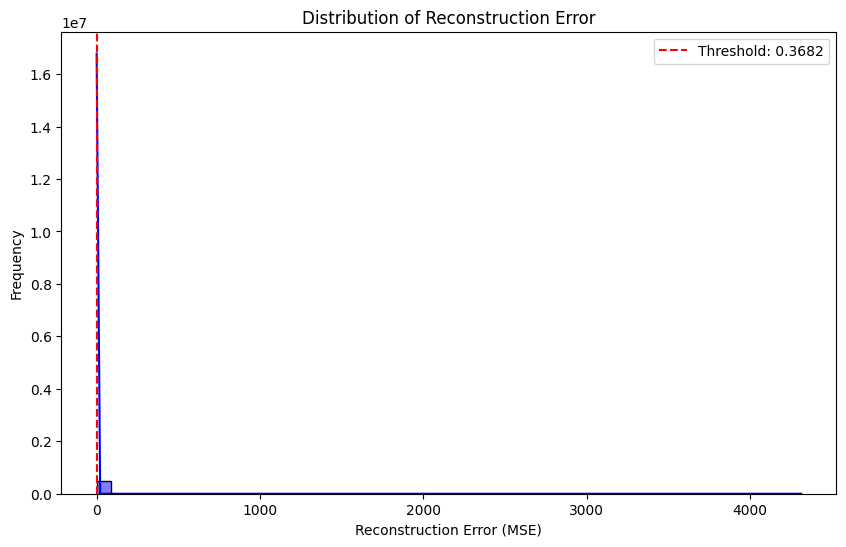

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(mse, bins=50, kde=True, color="blue")
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold: {threshold:.4f}")
plt.title("Distribution of Reconstruction Error")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_scaled)


C:\Users\RAJ MOHNANI\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


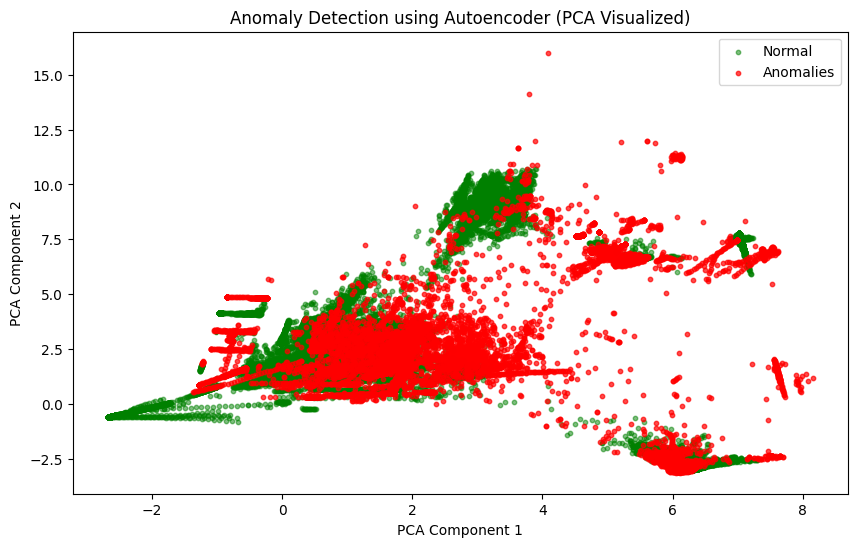

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(components[~anomalies, 0], components[~anomalies, 1], 
            label="Normal", alpha=0.5, s=10, c="green")
plt.scatter(components[anomalies, 0], components[anomalies, 1], 
            label="Anomalies", alpha=0.7, s=10, c="red")
plt.title("Anomaly Detection using Autoencoder (PCA Visualized)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [ ]:
plt.savefig("../imagesave")


<Figure size 640x480 with 0 Axes>